In [10]:
#import libraries
import numpy as np
import cv2
import pandas as pd
import random
import matplotlib.pyplot as plt

In [11]:
#extracting images name from Landmarks-Append
import re
with open('/home/gabriel/Documents/TR DIMA/data/Photos-Ailes-landmarks-UMons/Landmarks-Append', 'r') as fiche:
    text = fiche.read()
    liste = re.findall(r'(?<=IMAGE=)[^\n]+',text)
    print(len(liste))
    liste_2 = list(set(liste))
    print(liste_2,'\n',len(liste_2))
    for name in liste_2:
        if not '.' in name:
            print(name)
    L = liste_2

1788
['Bombus_natvi_M_BM0230.jpg', 'ApApApBoBomTriF_MD2628.JPG', 'Bombus_Polaris_Q_PHW0005.JPG', 'ApApApBoBomFerF_MD2730.JPG', 'L094IR.JPG', 'ApApApBoBomFunF_MD3087.jpg', 'ApApApBoBomPerF_MD2745.JPG', 'L172ITN.JPG', 'ApApApBoBomCalF_MD2334.JPG', 'Bombus_Hyperboreus_Q_BM0308.jpg', 'BterM_Col19_07D.JPG', 'L052HU.JPG', 'ApApApBoBomWalF_MD3232.jpg', 'Bombus_neoboreus_W_NHM058.JPG', 'Bombus_neoboreus_W_NHM059.JPG', 'Bombus_Polaris_Q_PHW0023.JPG', 'ApApApBoBomErzF_MD3081.jpg', 'ApApApBoBomPulF_MD2756.JPG', 'Bombus_pyrrhopygus_W_BM0083.jpg', 'L243RO.JPG', 'Bombus_kirb_W_BM0280.jpg', 'Bombus_Balteaus_W_BM0029.jpg', 'ApApApBoBomFunF_MD2414.JPG', 'Bombus_alpinus_W_PHW0040.JPG', 'Bombus_polaris_M_BM0218.jpg', 'L262SC.JPG', 'Bombus_Alpinus_Q_BM0127.jpg', 'ApApApBoBomConsF_MD3060.jpg', 'Bombus_neoboreus_Q_NHM_117.tif', 'ApApApBoBomVosF_MD2660.JPG', 'ApApApBoBomVagF_MD2639.JPG', 'ApApApBoBomIneF_MD3112.jpg', 'ApApApBoBomFedF_MD2857.jpg', 'ApApApBoBomHunF_MD2608.JPG', 'L042AT.JPG', 'L153HU.JPG', 'L07

In [12]:
#check that all the images I got are on the above list of annotation
import os

test_images_directory = '/home/gabriel/Documents/TR DIMA/data/Photos-Ailes-landmarks-UMons'


def list_directory_contents(directory):

    pictures_list = []

    try:
        with os.scandir(directory) as entries:
            for entry in entries:
                #print(entry.name)
                pictures_list.append(entry.name)
    except FileNotFoundError:
        print(f"The directory {directory} does not exist.")
    except NotADirectoryError:
        print(f"{directory} is not a directory.")
    except PermissionError:
        print(f"Permission denied to access {directory}.")
    return pictures_list

pictures_list = list_directory_contents(test_images_directory)
print(len(pictures_list))

count = 0
for name in pictures_list:
    if name not in L:
        print('found a mismatch')
        print(name)
        count += 1

if count == 0:
    print("no mismatch found") 
else :
    print(f"found {count} mismatch!")

L = list(set(L) & set(pictures_list))
print("len of L after cleaning: ",len(L))

1723
found a mismatch
ApApApBoBomExiF_MD2354.JPG
found a mismatch
Bombus_Polaris_Q_BM0087.jpg
found a mismatch
Bombus_Polaris_Q_BM0086.jpg
found a mismatch
Landmarks-Append
found a mismatch
Bombus_Polaris_Q_BM0085.jpg
found a mismatch
Bombus_Polaris_Q_BM0088.jpg
found 6 mismatch!
len of L after cleaning:  1717


In [13]:
#execute this cell only if you want to test preprocessing on a sample of all the dataset and not the entire dataset
#sampling (name of) images
#bonus = "Bombus_alpinus_Q_NHM032_010266225.JPG"

N_sample = 5
L_sampled = np.random.choice(L,N_sample)
L_sampled = list(L_sampled)
#L_sampled.append(bonus)

In [14]:
#extracting coordinates of annotated points 
#this is for displaying all the transformation process on few images

L_sampled_coordinates = []

with open('/home/gabriel/Documents/TR DIMA/data/Photos-Ailes-landmarks-UMons/Landmarks-Append', 'r') as fiche:
    text_enum = fiche.readlines()
    text_list = [line[:-1] for line in text_enum] #we create a list with all lines from Landmarks-Append
    for name in L_sampled:
        full_line = 'IMAGE=' + name
        index = text_list.index(full_line)
        coordinates = text_list[index-18:index] #we have then a list of coordinates, but not in the good format
        true_coordinates = np.array([re.split(r' ',coordinates[i]) for i in range(len(coordinates))],dtype = np.float32) #conversion to a more usable format
        L_sampled_coordinates.append(true_coordinates)

    


In [15]:
#this cell create a L_sampled_coordinate like list but for all images of L

L_coordinates = []

with open('/home/gabriel/Documents/TR DIMA/data/Photos-Ailes-landmarks-UMons/Landmarks-Append', 'r') as fiche:
    text_enum = fiche.readlines()
    text_list = [line[:-1] for line in text_enum] #we create a list with all lines from Landmarks-Append
    for name in L:
        full_line = 'IMAGE=' + name
        index = text_list.index(full_line)
        coordinates = text_list[index-18:index] #we have then a list of coordinates, but not in the good format
        true_coordinates = np.array([re.split(r' ',coordinates[i]) for i in range(len(coordinates))],dtype = np.float32) #conversion to a more usable format
        L_coordinates.append(true_coordinates)

2000 3008 3


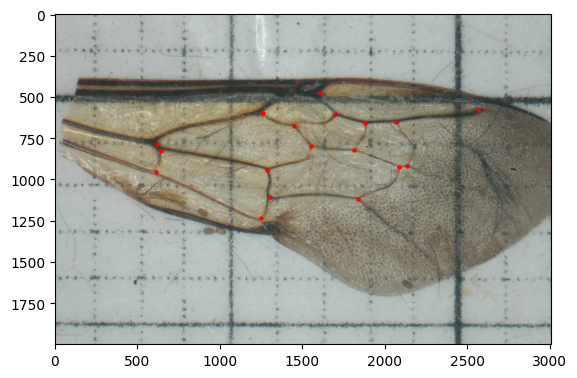

1920 2560 3


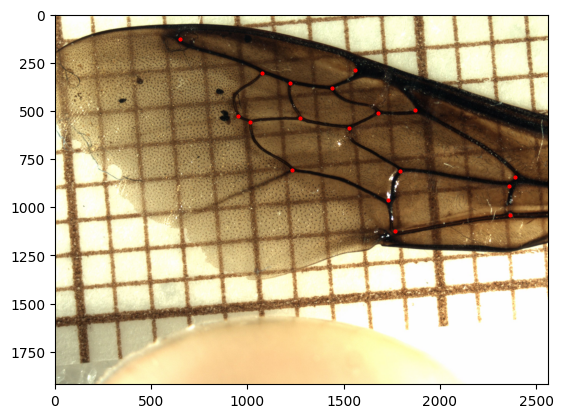

2000 3008 3


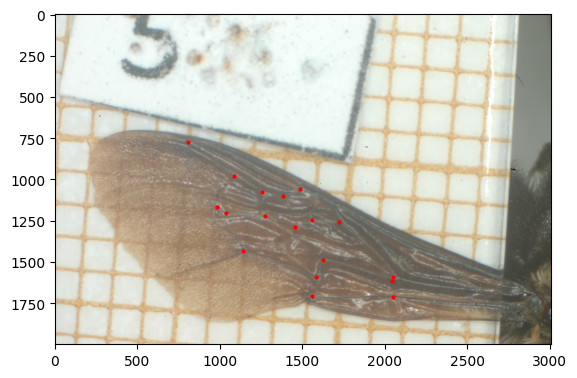

2000 3008 3


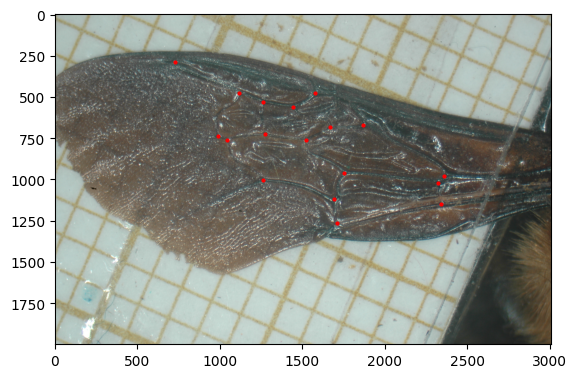

2000 3008 3


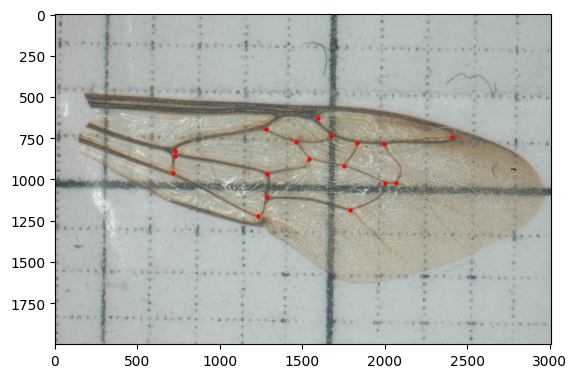

In [17]:
#creating arrays for storing annotations and transformed images (I will then save transformed images into a new dataset to avoid high memory overloading)
#run this cell only if you are testing with the sample (not the full dataset, and this will not work)

annotations = []
transformed_images = []


#let's plot images with annotated points
for i,image_name in enumerate(L_sampled):
    im = cv2.imread(test_images_directory+'/'+image_name)
    image_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    x,y,z = image_rgb.shape
    print(x,y,z)
    if x > y:
        image_rgb = np.rot90(image_rgb) #thinks does work well when image vertical, but it's necessary to update original annotations
        pass
    plt.imshow(image_rgb)
    transformed_images.append(image_rgb)
    current_annotations = []
    if x > y:
        for pt in L_sampled_coordinates[i]:
            plt.plot(pt[0],y-pt[1],'ro',markersize = 2)
            current_annotations.append([pt[0],y-pt[1]])
    else :
        for pt in L_sampled_coordinates[i]:
            plt.plot(pt[0],x-pt[1],'ro',markersize = 2)
            current_annotations.append([pt[0],x-pt[1]])
    annotations.append(current_annotations)
    #plt.axis('off')
    plt.show()
annotations = np.array(annotations) #type convertion

(5, 18, 2)
True 2568.0 1608.0
angle avant preprocessing 5.9468627 °


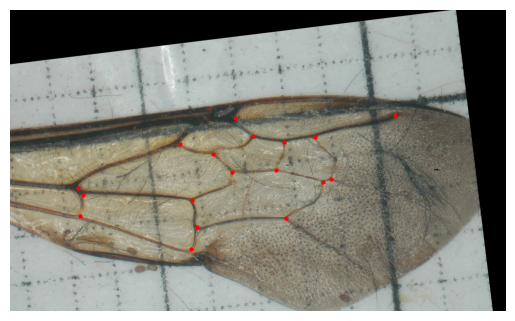

(5, 18, 2)
False 651.0 1560.0
angle avant preprocessing 9.982808 °


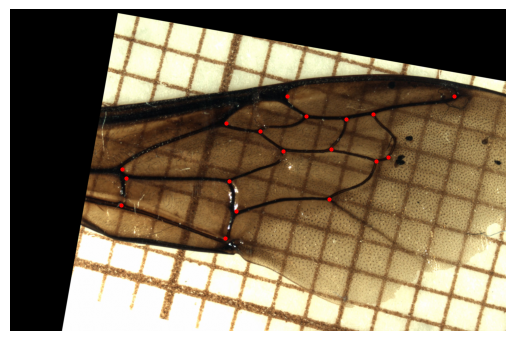

(5, 18, 2)
False 804.0 1485.0
angle avant preprocessing 22.637785 °


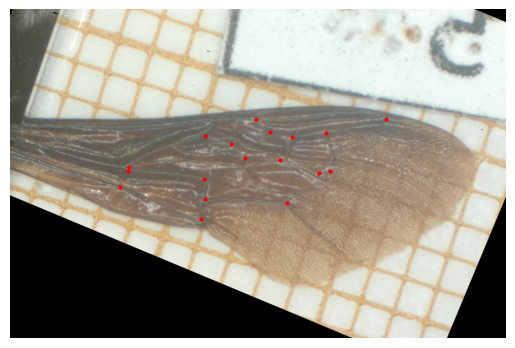

(5, 18, 2)
False 731.0 1575.0
angle avant preprocessing 12.298589 °


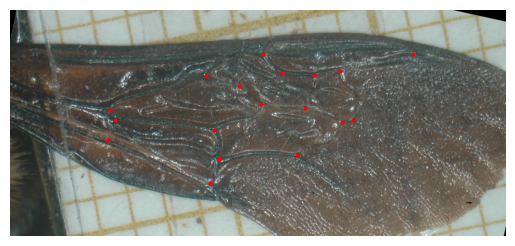

(5, 18, 2)
True 2410.0 1593.0
angle avant preprocessing 8.287129 °


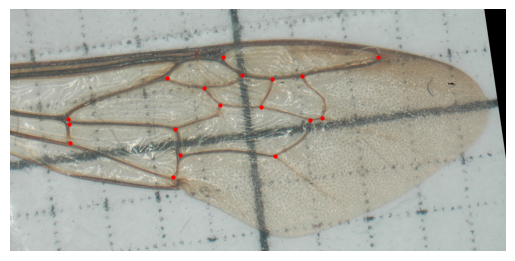

In [18]:
#in this cell, we are going to compute the angle of each wing based on the orientation of up side cell. We are going first to do display each point separately in order to to isolate the two points that are needed for the process.
#We will use this 2 points to know if we have to flip or not.
#first, for a given image, I will display each point
import scipy.ndimage
from skimage.transform import AffineTransform, warp

#few changes there regarding of the precedent version. First, I'm not gonna put all images to angle 0, and allow rotation from -10° to 10°
#for the cropping, a less restrictive crop will be applied, with higher margins, and some randomness in the margin design (eg points not always centered)
ANGLE_TRESH = 7 #in degree

# Function to rotate points using AffineTransform
def rotate_points_affine(points, angle, translation):
    transform = AffineTransform(rotation=np.deg2rad(angle), translation=[0,0])
    rotated_points = transform(points)
    rotated_points += translation
    return rotated_points


for index in range(len(transformed_images)):


    image_test = transformed_images[index]
    print(annotations.shape)
    points_test = annotations[index]
    relevant_pts = points_test[:2]
    orientation = relevant_pts[0,0]>relevant_pts[1,0]   
    print(orientation,relevant_pts[0,0],relevant_pts[1,0])
    angle = np.arctan((relevant_pts[1]-relevant_pts[0])[1]/(relevant_pts[1]-relevant_pts[0])[0])
    print("angle avant preprocessing",angle*180/np.pi,"°")

   




    # Rotate the points
    rotated_points = rotate_points_affine(points_test, -np.sign(angle*180/np.pi)*max(abs(angle*180/np.pi),ANGLE_TRESH),translation = np.array([0,0])) #don't considere the translation, just here to show how this works

    #we introduce these variable to extract a bounding box and then extract the relevant points of the wing before training the UNet (or any other model)
    min_x = np.int64(np.min(rotated_points[:,0]))
    min_y = np.int64(np.min(rotated_points[:,1]))
    max_x = np.int64(np.max(rotated_points[:,0]))
    max_y = np.int64(np.max(rotated_points[:,1]))

    margin_min = 200
    margin_random_range = 500
    margin_ix = margin_min + int(np.random.random()*margin_random_range)
    margin_iy = margin_min + int(np.random.random()*margin_random_range)
    margin_ax = margin_min + int(np.random.random()*margin_random_range)
    margin_ay = margin_min + int(np.random.random()*margin_random_range)

    bbox = np.array([[min_x-margin_ix,min_y-margin_iy],[min_x-margin_ix,max_y+margin_ay],[max_x+margin_ax,max_y+margin_ay],[max_x+margin_ax,min_y-margin_iy],[min_x-margin_ix,min_y-margin_iy]])

    top_left = bbox[0]

    crop_size = (max_x-min_x+margin_ix+margin_ax,max_y-min_y+margin_iy+margin_ay)
    crop_trans = -np.array([top_left[0],top_left[1]])


    # Rotate and translate the image
    transform = AffineTransform(rotation=-np.sign(angle)*max(abs(angle),ANGLE_TRESH*np.pi/180), translation=crop_trans)
    rotated_image = warp(image_test, transform.inverse,output_shape = [crop_size[1],crop_size[0]])


    # # Translate the image
    # transform_2 = AffineTransform(rotation=0, translation=crop_trans)
    # cropped_image = warp(rotated_image, transform_2.inverse,output_shape = [crop_size[1],crop_size[0]])

    #Translate the points
    translated_points = rotate_points_affine(rotated_points, 0,translation = crop_trans)

    #plotting the cropped image
    #plt.plot(bbox[:,0],bbox[:,1],'b')
    #plt.plot(rotated_points[:,0],rotated_points[:,1],'ro')
    # plt.imshow(rotated_image)
    # plt.axis('off')
    # plt.show()

    #flip the image when not in the good orientation
    if orientation == False:
        rotated_image = rotated_image[:,::-1,:]
        x,y,z = rotated_image.shape
        translated_points[:,0] = y-translated_points[:,0]


    #plotting the cropped images with the transformed points
    plt.imshow(rotated_image)
    plt.plot(translated_points[:,0],translated_points[:,1],'ro',markersize = 2)
    plt.axis('off')
    plt.show()




In [19]:
#this cell will store a function that take an image as input and apply of above mentionned transformations, and return the transformed image, with transformed annotations 
from skimage.transform import resize

def image_transform(image,annotation,image_shape):
    """this function take a image from Umons dataset (in brg format, rgb translation integrated) and transform it as shown above"""
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    x,y,z = image_rgb.shape
    #print(x,y,z)
    if x > y:
        image_rgb = np.rot90(image_rgb) #thinks does work well when image vertical, but it's necessary to update original annotations
        pass
    #plt.imshow(image_rgb)
    current_annotations = []
    if x > y:
        for pt in annotation:
            #plt.plot(pt[0],y-pt[1],'ro',markersize = 2)
            current_annotations.append([pt[0],y-pt[1]])
    else :
        for pt in annotation:
            #plt.plot(pt[0],x-pt[1],'ro',markersize = 2)
            current_annotations.append([pt[0],x-pt[1]])
    current_annotations = np.array(current_annotations)
    #plt.axis('off')
    #plt.show()

    image_test = image_rgb
    points_test = current_annotations
    relevant_pts = points_test[:2]
    orientation = relevant_pts[0,0]>relevant_pts[1,0]   
    #print(orientation,relevant_pts[0,0],relevant_pts[1,0])
    angle = np.arctan((relevant_pts[1]-relevant_pts[0])[1]/(relevant_pts[1]-relevant_pts[0])[0])
    #print(angle)

   




    # Rotate the points
    rotated_points = rotate_points_affine(points_test,-np.sign(angle*180/np.pi)*max(abs(angle*180/np.pi),ANGLE_TRESH),translation = np.array([0,0])) 

    #we introduce these variable to extract a bounding box and then extract the relevant points of the wing before training the UNet (or any other model)
    min_x = np.int64(np.min(rotated_points[:,1]))
    min_y = np.int64(np.min(rotated_points[:,0]))
    max_x = np.int64(np.max(rotated_points[:,1]))
    max_y = np.int64(np.max(rotated_points[:,0]))

    xi = max_x - min_x
    yi = max_y - min_y

    margin_min = 200/1000 #this mean we will let 150/1000 of x or y size on top or sides, this will be adapted regarding which on is to satisfy
    margin_random = 300/1000

    xs,ys,_ = image_shape

    key_factor = (yi*xs)/(ys*xi)
    fraction = min(max(np.random.random(),0.3),0.7)

    if key_factor < 1:
        margin_xi = margin_min + np.random.random()*margin_random
        margin_xa = margin_min + np.random.random()*margin_random
        margin_yi = ((1+margin_xi+margin_xa)/key_factor -1)*fraction
        margin_ya = ((1+margin_xi+margin_xa)/key_factor -1)*(1-fraction)
    else:
        margin_yi = margin_min + np.random.random()*margin_random
        margin_ya = margin_min + np.random.random()*margin_random
        margin_xi = ((1+margin_yi+margin_ya)*key_factor -1)*fraction
        margin_xa = ((1+margin_yi+margin_ya)*key_factor -1)*(1-fraction)

    bbox = np.array([[min_x-margin_xi*xi,min_y-margin_yi*yi],[min_x-margin_xi*xi,max_y+margin_ya*yi],[max_x+margin_xa*xi,max_y+margin_ya*yi],[max_x+margin_xa*xi,min_y-margin_yi*yi],[min_x-margin_xi*xi,min_y-margin_yi*yi]])

    top_left = bbox[0]

    crop_size = (np.int64(max_x-min_x+(margin_xa+margin_xi)*xi),np.int64(max_y-min_y+(margin_ya+margin_yi)*yi))
    crop_trans = -np.array([top_left[1],top_left[0]])


    # Rotate and translate the image
    transform = AffineTransform(rotation=-np.sign(angle)*max(abs(angle),ANGLE_TRESH*np.pi/180), translation=crop_trans)
    rotated_image = warp(image_test, transform.inverse,output_shape = [crop_size[0],crop_size[1]])

    #reshape image and annotations
    reshaped_transformed_image = resize(rotated_image, (xs,ys), anti_aliasing=True)



    # # Translate the image
    # transform_2 = AffineTransform(rotation=0, translation=crop_trans)
    # cropped_image = warp(rotated_image, transform_2.inverse,output_shape = [crop_size[1],crop_size[0]])

    #Translate the points
    translated_points = rotate_points_affine(rotated_points, 0,translation = crop_trans)
    
    #reshape points
    translated_points[:,0] = translated_points[:,0]*ys/((1+margin_ya+margin_yi)*yi)
    translated_points[:,1] = translated_points[:,1]*xs/((1+margin_xa+margin_xi)*xi) #for points, x = y

    #plotting the cropped image
    #plt.plot(bbox[:,0],bbox[:,1],'b')
    #plt.plot(rotated_points[:,0],rotated_points[:,1],'ro')
    # plt.imshow(rotated_image)
    # plt.axis('off')
    # plt.show()

    #flip the image when not in the good orientation
    if orientation == False:
        reshaped_transformed_image = reshaped_transformed_image[:,::-1,:]
        translated_points[:,0] = ys-translated_points[:,0]


    #plotting the cropped images with the transformed points
    # plt.imshow(rotated_image)
    # plt.plot(translated_points[:,0],translated_points[:,1],'ro',markersize = 2)
    # plt.axis('off')
    # plt.show()

    return reshaped_transformed_image,translated_points


    
    




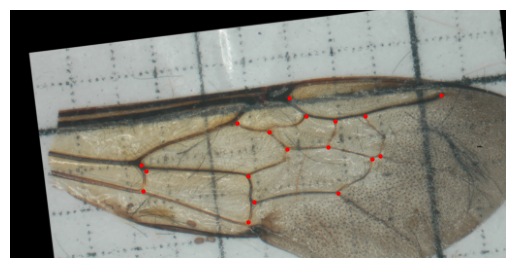

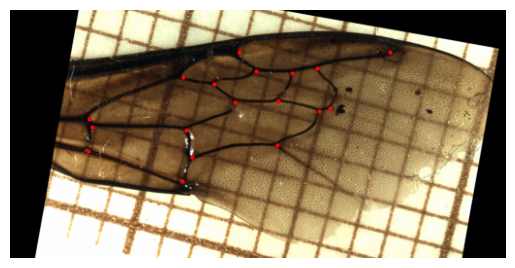

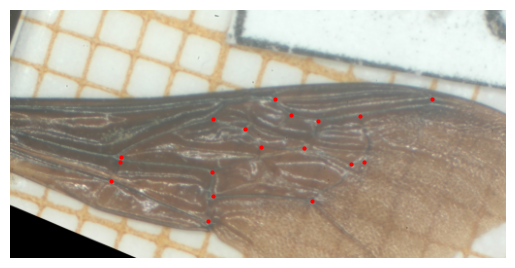

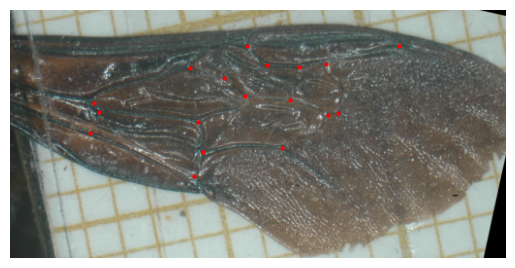

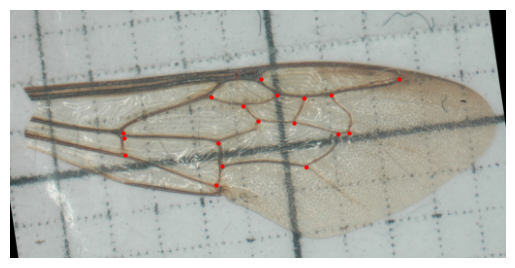

In [20]:
#let's test the function for the already loaded images
for i in range(len(L_sampled)):
    image_name = L_sampled[i]
    image = cv2.imread(test_images_directory+'/'+image_name)
    annotation = L_sampled_coordinates[i]
    image_shape = (256,512,3)
    transformed_image,transformed_annotation = image_transform(image,annotation,image_shape)

    plt.imshow(transformed_image)
    plt.plot(transformed_annotation[:,0],transformed_annotation[:,1],'ro',markersize = 2)
    plt.axis('off')
    plt.show()

#this seem to work pretty well, now let's try to apply it for all images and save new images and new annotations


In [22]:
new_dataset_directory = "/home/gabriel/Documents/TR DIMA/data/UMons_preprocessed_images_v2"
new_annotations_directory = "/home/gabriel/Documents/TR DIMA/data/UMons_preprocessed_images_annotations_v2"
image_shape = (256,512,3)

In [ ]:
#this cell has to be executed only once
#please ensure the directories for saving are correct
import imageio
import time


start_time = int(time.time())

for index,image_name in enumerate(L):
        image = cv2.imread(test_images_directory+'/'+image_name)
        annotation = L_coordinates[index]
        transformed_image,transformed_annotation = image_transform(image,annotation,image_shape)
        transformed_image = np.array(transformed_image*255,dtype = np.uint8)

        # Save the image
        imageio.imwrite(new_dataset_directory+f'/UMons_preprocessed_image_v2_{index}.png', transformed_image)

        #save associated annotation (we will save one file by annotation)

        # Save the array to a file
        np.save(new_annotations_directory+f'/UMons_preprocessed_data_annotations_v2_{index}.npy', transformed_annotation)

        if index%50 == 0:
                current_time = int(time.time())
                current_duration = current_time-start_time
                print(f"in progress,{index//50*50}/{len(L)},time : {current_duration} s")

    

in progress,0/1717,time : 1 s
in progress,50/1717,time : 28 s
in progress,100/1717,time : 51 s
in progress,150/1717,time : 82 s
in progress,200/1717,time : 109 s
in progress,250/1717,time : 135 s
in progress,300/1717,time : 164 s
in progress,350/1717,time : 197 s
in progress,400/1717,time : 219 s
in progress,450/1717,time : 245 s
in progress,500/1717,time : 275 s
in progress,550/1717,time : 305 s
in progress,600/1717,time : 330 s
in progress,650/1717,time : 353 s
in progress,700/1717,time : 382 s
in progress,750/1717,time : 410 s
in progress,800/1717,time : 435 s
in progress,850/1717,time : 457 s
in progress,900/1717,time : 486 s
in progress,950/1717,time : 513 s
in progress,1000/1717,time : 541 s
in progress,1050/1717,time : 564 s
in progress,1100/1717,time : 589 s
in progress,1150/1717,time : 617 s
in progress,1200/1717,time : 647 s
in progress,1250/1717,time : 679 s
in progress,1300/1717,time : 710 s
in progress,1350/1717,time : 741 s
in progress,1400/1717,time : 767 s
in progress,1

In [ ]:
#opening testing (to make sure there are no issue with saving. A visual check should be done for all images too)
#problematic : 581,1246, other are all OK. I removed manually these images
#this cell must be used to display some images after manual sorting to see if the preprocessing effectively failed on theses images
image_list = ["UMons_preprocessed_image_581.png","UMons_preprocessed_image_1246.png"]
print(image_list)

for name in image_list:

    image = cv2.imread(new_dataset_directory+'/'+name)   
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    

    # Regular expression to extract the number
    match = re.search(r'_(\d+)\.png', name)

    number = int(match.group(1))

    annotation = np.load(new_annotations_directory+'/'+f'UMons_preprocessed_data_annotations_{number}.npy')
    plt.imshow(image_rgb)
    plt.plot(annotation[:,0],annotation[:,1],'ro',markersize = 2)
    plt.show()

    